Testing basic interference because wtf.

In [2]:
import numpy as np
import matplotlib.pyplot as pl
import itertools
from mpl_toolkits.mplot3d import Axes3D
from RayTraceFun_forDet import *
from PossibleFunctionsDet import *
from BackgroundDet import *
from random import uniform
import random
import matplotlib
import pickle
import time #to save figs automatically time.strftime("%Y_%m_%d_%s")
#%matplotlib auto

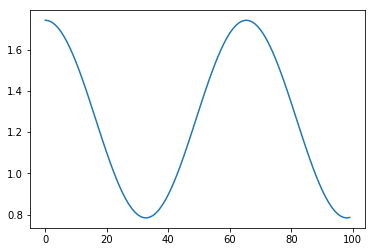

In [3]:
d = np.linspace(0,5,100) #difference in path length
D1 = [1 for x in d] #path length of ONE ray
D2 = [x + 1 for x in d] #path length of SECOND RAY
Ds = []
Ds.append(D1)
Ds.append(D2)
thet = 2*np.pi*random.random() #random
I = random.random() #random
thet2 = 2*np.pi*random.random() #random
I2 = random.random() #random
Ij = []
pathdiff = []
Ijreal = []
for i in range(len(D1)):
    Lamd = 3.3
    phase = np.exp(1j*(D1[i]%Lamd)*2*np.pi/Lamd)
    Ex1 = I*np.cos(thet)
    Ey1 = I*np.sin(thet)
    Ex = Ex1*phase
    Ey = Ey1*phase
    #SECOND PART
    phase2 = np.exp(1j*(D2[i]%Lamd)*2*np.pi/Lamd)
    Ex12 = I2*np.cos(thet2)
    Ey12 = I2*np.sin(thet2)
    Ex2 = Ex12*phase2
    Ey2 = Ey12*phase2
    ExTot = Ex + Ex2
    EyTot = Ey + Ey2
    Ij.append((ExTot*ExTot.conjugate() + EyTot*EyTot.conjugate()).real)
    Ijreal.append(ExTot.real**2 + EyTot.real**2)
    pathdiff.append(i)
pl.plot(pathdiff,Ij)
pl.show()
#OK SO IT WORKS SO JUST IMPLEMENT IT WITH ALL 8 RAYS 

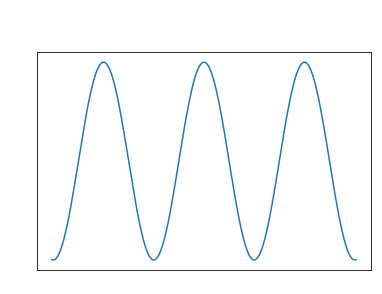

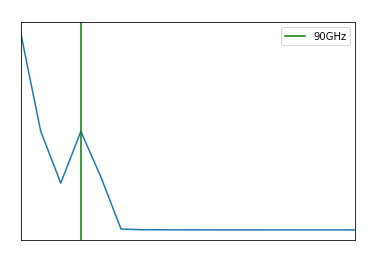

In [5]:
#ok so this shows that path difference SHOULD FUCKING LEAD TO INTERFERENCE AS EXPECTED
d = np.linspace(-5,5,2**8) #difference in path length
D1 = [1 for x in d] #path length of ONE ray
D2 = [x + 1 for x in d] #path length of SECOND RAY
Ds = []
Ds.append(D1)
Ds.append(D2)
thet = 2*np.pi*random.random() #random
I = random.random() #random
#thet2 = 2*np.pi*random.random() #random
#I2 = random.random() #random
Ij = []
pathdiff = []
Ijreal = []
for i in range(len(D1)):
    Lamd = 3.3
    ExTot = 0 #initial power (no rays)
    EyTot = 0
    for k in range(2):
        phase = np.exp(1j*(Ds[k][i]%Lamd)*2*np.pi/Lamd)
        Ex1 = I*np.cos(thet)
        Ey1 = I*np.sin(thet)
        Ex = Ex1*phase
        Ey = Ey1*phase
        ExTot = ExTot + Ex
        EyTot = EyTot + Ey
    Ij.append((ExTot*ExTot.conjugate() + EyTot*EyTot.conjugate()).real)
    Ijreal.append(ExTot.real**2 + EyTot.real**2)
    pathdiff.append(i)
pl.plot(d,Ij)
pl.tick_params(colors = 'white')
pl.title('Hypothetical Interferogram\nUsing hypothetical path differences\n$\lambda$=3.3mm',color = 'white')
pl.show()

d1 = Ij
D = np.hanning(int(np.shape(d1)[0]))*d1
S = np.fft.rfft(D)
S = S[0:-1]
u = np.abs(S)

dx = 10/(2**8)
Nsize = 2**8
dNu = 1/(Nsize*dx)
Nu = dNu*np.arange(Nsize/2)
pl.plot(300*Nu,u)
pl.xlim(0,500)
pl.title('FFT of above',color = 'white')
pl.xlabel('Should be GHz?', color = 'white')
pl.tick_params(colors = 'white')
pl.axvline(x =90, color = 'green', label = '90GHz')

pl.legend()
pl.show()
#SO THIS FFT WORKS. GODDDAMNIT. 
# i mean good, but something is wrong in my ACTUAL PROGRAM then...
#OK SO IT WORKS SO JUST IMPLEMENT IT WITH ALL 8 RAYS 
#yeah so this is fundamentally wrong because it just returns a flat line.
#this should show the interference of the two rays leading to different Ex and Ey
#this different Ex and Ey should lead to difference in power as a function of path difference

In [7]:
#NOW USING SIMULATION DATA
def OFDM(Rays,y): #output from detector with mirror at Y
    Rayf = []
    for i in range(len(Rays)):
        Paths = [TTTTioM,RRRRioM,TTRRioM,RTTRioM,RTRTioM,TRRTioM,RRTTioM,TRTRioM]
        Ri = Rays[i]
        for j in range(8):
            origin = (0,y,0)
            out = Paths[j](Ri,p1,p2,p3,p4,origin)
            if out is not None:
                Rayf.append(out)
    return Rayf

def checkoutraysM(Rays,center,r): #RAYS THAT HIT DETECTOR
    GRays = []
    for i in range(len(Rays)):
        det = PLINTzS(80.,Rays[i][2],Rays[i][3])
        Rays[i][2] = det
        Rays[i][0] = Rays[i][0] + np.pi #reflection changes polarization
        d = ((det[0]-center[0])**2) + ((det[1]-center[1])**2) #if it is within detector
        if d <= r**2: 
            GRays.append(Rays[i])
    return GRays

def RunRaysMi(Rays,y): #just give number of rays to be run through this FTS at a specific y!
    Rayf = OFDM(Rays,y)
    G= checkoutraysM(Rayf,[160.375,-113],7.9375) # GOOD RAYS ONLY 
    Gtestsorted = sortgrid(G)
    Regions = regionalize(Gtestsorted)
    return Gtestsorted,Regions


def makeraysiFIXED(n,r):
    sourcepointorigin = [-160.375,-113.,-80.0] #LOCAL 
    sourcethet = [0.,0.,0.] #SHOT STRAIGHT UP
    sourcepoints = specsource(r,sourcepointorigin,sourcethet,n) # SOURCE
    Rays = FSRay(n,sourcepoints, sourcethet,origin10)
    for i in range(n):
        Rays[i][2] = sourcepointorigin
        v1x,v1y,v1z = transformLG(0.,0.,1,originG,sourcethet)
        v2 = sepop(v1x,v1y,v1z)
        Rays[i][3]=v2
    return Rays

def SumjRegionsMi_TestG(Rays,y): #ALSO INCORPORATES PHASE
    OutRays,regions=RunRaysMi(Rays,y)
    Regions = list(regions)
    jx,jy = gridlines(7.9375,[160.375,-113],200)
    LamdAll = np.linspace(1, 10,300) #possible wavelengths (30-300 Ghz), steps of 1Ghz
    DetTot = []
    for j in range(len(regions)):
        ExTot = []
        EyTot = []
        for i in range(len(Regions[j])): #All rays in region j
            #ExTot = []
            #EyTot = []
            if i != 0 and i != 1:
                JRegion = Regions[j]
                o,p = JRegion[0],JRegion[1] # jx and jy defining the jth region
                Raym = OutRays[JRegion[i]] #ith ray in the jth region
                if o != len(jx)-1 and p !=len(jy)-1:
                    #w = 1
                    w = gaussian3d(Raym[2][0],Raym[2][1],.4,(jx[o]+jx[o+1])/2,(jy[p]+jy[p+1])/2)
                else: 
                    w = 0 #(skipping gaussian)
                #Raym[1] is intensity!!! #split into x and y components of AMPLITUDE field
                #w = 1
                I = Raym[1]
                thet = Raym[0]
                Ex1,Ey1 = w*np.sqrt(I)*np.cos(thet),w*np.sqrt(I)*np.sin(thet) #multiplied by gaussian
                #only one frequency 
                Lamd = 3.3
                phase = np.exp(1j*(Raym[4]%Lamd)*2*np.pi/Lamd)
                #phase = np.exp(2*np.pi*1j*Raym[4]/Lamd)
                Ex = Ex1*phase
                Ey = Ey1*phase
                ExTot.append(Ex)
                EyTot.append(Ey)
        Ij = (np.sum(ExTot)*np.sum(ExTot).conjugate()) + (np.sum(EyTot)*np.sum(EyTot).conjugate())
        DetTot.append(Ij.real)
    return np.sum(DetTot)

def RunFTSLimiStraightTest(n,r,div,Lim):
    Power = []
    Delay = []
    Rays = makeraysiFIXED(n,r)
    for y in np.linspace(-int(Lim),int(Lim),div):
        I = SumjRegionsMi_TestG(Rays,y)
        Power.append(I)
        Delay.append(y)
    return Power,Delay 

#is normalized now
def Airygaussian3dNORM(x,y,sig,mux,muy): #assuming is symmetric, making peak = 1
   # A = 1
    A = (1/((sig**3)*(2*np.pi)**(3/2)))
    return A*np.exp(-(((x-mux)**2)/(2*sig**2) + ((y-muy)**2)/(2*sig**2)))

def Airygaussian3d(x,y,sig,mux,muy): #assuming is symmetric, making peak = 1
    A = 1
    #A = (1/((sig**3)*(2*np.pi)**(3/2)))
    return A*np.exp(-(((x-mux)**2)/(2*sig**2) + ((y-muy)**2)/(2*sig**2)))

#given LAST ray and its wavelength, return sig, mux and muy to then be used in gaussian  
#see pg 79 for more details(approx of airy func)
def MakeGaussian(Ray,Lamd):
    mux,muy = Ray[2][0],Ray[2][1] #center of gaussian is intersection point
    width = 3.0988*Lamd
    sig = width/3
    return sig,mux,muy

#given the two positions of the last rays and wavelength, returns percentage of overlap (out of 1)
def gaussoverlap(Ray1,Ray2,Lamd):
    sig1,mux1,muy1 = MakeGaussian(Ray1,Lamd)
    sig2,mux2,muy2 = MakeGaussian(Ray2,Lamd)
    p1 = [mux1,muy1,80.] #points in 3d in GLOBAL coordinates
    p2 = [mux2,muy2,80.]
    MDValue = dist(p1,p2)
    MD = [0,.25,.5,.75,1,1.1,1.2,1.3,1.5,1.7,1.9,2.1,2.3,2.6,2.9,3.4,3.7,3.9] #mean difference
    GP = [1,.9,.8,.7,.62,.6,.55,.5,.45,.4,.35,.3,.25,.2,.15,.1,.07,.05] #Gaussian Percent
    idx = (np.abs(MD-MDValue)).argmin() #index number in array for closest value
    return GP[idx]

#find CENTER of each pixel now as [x,y]
def MakePixels(jx,jy):
    pix = []
    for o in range(len(jx)-1):
        for p in range(len(jy)-1):
            r = 7.9375
            xpix,ypix= (jx[o]+jx[o+1])/2,(jy[p]+jy[p+1])/2
            d = np.sqrt((xpix-160.375)**2 + ((ypix-(-113))**2))
            if d <= r: 
                pix.append([xpix,ypix])
    return pix


n = 1
r = 0
Rays = makeraysiFIXED(n,r) 
jx,jy = gridlines(7.9375,[160.375,-113],200) #these are now the PIXELS
Pix = MakePixels(jx,jy) #center of each pixel
Ij = []
Delay = []
print('Running...')
OutRay0 = []
OutRay5 = []
for y in np.linspace(-18,18,2**8):
    Lamd = 3.3
    ExTot = 0 #initial E field (no rays)
    EyTot = 0
    ETot = 0
    OutRays,regions=RunRaysMi(Rays,y) #eight each
    OutRay0.append(OutRays[0][4])
    OutRay5.append(OutRays[5][4])

Running...


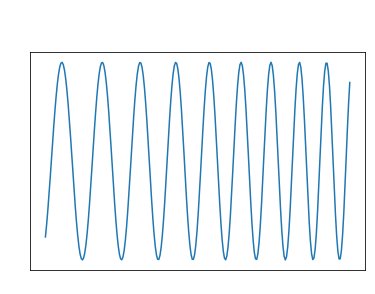

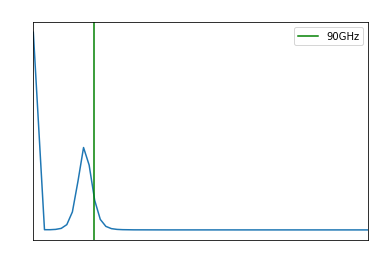

In [10]:
#ok so this shows that path difference SHOULD FUCKING LEAD TO INTERFERENCE AS EXPECTED
d = np.linspace(-5,5,2**8) #difference in path length
D1 = [1 for x in d] #path length of ONE ray
#D1 = []
#D2 = [x + 1 for x in d] #path length of SECOND RAY
Ds = []
#Ds.append(OutRay0)
#TRYING WITH HALF SIMULATION AND HALF mathematical
Ds.append(D1) #'baseline'
Ds.append(OutRay5) #CHANGING
#Ds.append(D2)
#Ds.append(D2)
thet = 2*np.pi*random.random() #random
I = random.random() #random
#thet2 = 2*np.pi*random.random() #random
#I2 = random.random() #random
Ij = []
pathdiff = []
Ijreal = []
for i in range(len(D1)):
    Lamd = 3.3
    ExTot = 0 #initial power (no rays)
    EyTot = 0
    for k in range(2):
        phase = np.exp(1j*(Ds[k][i]%Lamd)*2*np.pi/Lamd)
        Ex1 = I*np.cos(thet)
        Ey1 = I*np.sin(thet)
        Ex = Ex1*phase
        Ey = Ey1*phase
        ExTot = ExTot + Ex
        EyTot = EyTot + Ey
    Ij.append((ExTot*ExTot.conjugate() + EyTot*EyTot.conjugate()).real)
    Ijreal.append(ExTot.real**2 + EyTot.real**2)
    pathdiff.append(i)
pl.plot(d,Ij)
pl.tick_params(colors = 'white')
pl.title('Hypothetical Interferogram\nUsing hypothetical path differences\n$\lambda$=3.3mm',color = 'white')
pl.show()

d1 = Ij
D = np.hanning(int(np.shape(d1)[0]))*d1
S = np.fft.rfft(D)
S = S[0:-1]
u = np.abs(S)

dx = 36/(2**8)
Nsize = 2**8
dNu = 1/(Nsize*dx)
Nu = dNu*np.arange(Nsize/2)
pl.plot(300*Nu,u)
pl.xlim(0,500)
pl.title('FFT of above',color = 'white')
pl.xlabel('Should be GHz?', color = 'white')
pl.tick_params(colors = 'white')
pl.axvline(x =90, color = 'green', label = '90GHz')

pl.legend()
pl.show()
#SO THIS FFT WORKS. GODDDAMNIT. 
# i mean good, but something is wrong in my ACTUAL PROGRAM then...
#OK SO IT WORKS SO JUST IMPLEMENT IT WITH ALL 8 RAYS 
#yeah so this is fundamentally wrong because it just returns a flat line.
#this should show the interference of the two rays leading to different Ex and Ey
#this different Ex and Ey should lead to difference in power as a function of path difference

In [ ]:
#SO I THINK ABOVE IS WHAT HAPPENS WITH THE FACTOR OF TWO AND MEANS THAT WHAT I GET IN 
#FIXING_POWER 5 IS CORRECT :O / WHAT EXPECTED?